## Importing the libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.5.0'

## Loading and pre-processing the dataset

In [2]:
(X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
X_train.shape

(60000, 28, 28)

In [4]:
28 * 28

784

In [5]:
y_train.shape

(60000,)

In [6]:
np.random.randint(0, 60000)

19999

9


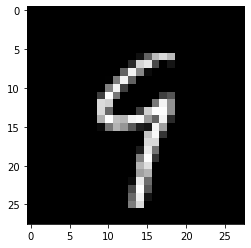

In [7]:
i = np.random.randint(0, 60000)
print(y_train[i])
plt.imshow(X_train[i], cmap='gray');

In [8]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

In [9]:
X_train.shape

(60000, 28, 28, 1)

In [10]:
X_train[0].min(), X_train[0].max()

(0.0, 255.0)

In [11]:
# X_train = X_train / 255
X_train = (X_train - 127.5) / 127.5

In [12]:
X_train[0].min(), X_train[0].max()

(-1.0, 1.0)

In [13]:
buffer_size = 60000
batch_size = 256

In [14]:
buffer_size / batch_size

234.375

In [15]:
type(X_train)

numpy.ndarray

In [16]:
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

In [17]:
type(X_train)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [18]:
X_train

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

## Building the generator

- Batch normalization: https://keras.io/api/layers/normalization_layers/batch_normalization/
- Leaky Relu: https://keras.io/api/layers/activation_layers/leaky_relu/
- Activation functions: https://medium.com/@himanshuxd/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e
- Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow

In [19]:
7*7*256

12544

In [20]:
def build_generator():
    network = tf.keras.Sequential()

    network.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100, )))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())

    network.add(layers.Reshape((7, 7, 256)))

      # 7x7x128
    network.add(layers.Conv2DTranspose(128, (5,5), padding='same', use_bias=False))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())

    # 14x14x64
    network.add(layers.Conv2DTranspose(64, (5,5), strides = (2,2), padding='same', use_bias=False))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())

    # 28x28x1
    network.add(layers.Conv2DTranspose(1, (5,5), strides = (2,2), padding='same', use_bias=False, activation='tanh'))

    network.summary()

    return network

In [21]:
generator = build_generator()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [22]:
noise = tf.random.normal([1, 100])

In [23]:
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-0.25967613,  1.0263345 ,  0.6486639 ,  1.6662844 ,  0.37475872,
         1.7228143 , -0.45282584, -0.32195282, -0.01536144, -0.46027955,
         0.09496802,  0.04759969,  1.5545255 , -0.68152124, -0.22036527,
         0.1737052 , -1.1288764 , -0.7123868 , -1.3348023 ,  1.2235591 ,
        -0.86148715, -0.6954975 , -0.92313033, -0.78729236, -0.5837089 ,
         3.5469532 ,  0.23271573,  2.0499866 , -1.5367044 ,  0.5159788 ,
         0.2417577 , -0.55348444, -2.212355  , -1.1687604 , -0.56147265,
         0.17518088, -0.73691547,  0.09299523,  0.85860693,  0.48348436,
        -2.3714967 , -0.5579118 ,  1.724667  , -1.0215774 ,  2.2957664 ,
        -0.5840059 , -0.3929355 , -1.2950137 ,  0.9304117 , -0.33516997,
        -2.2026634 , -0.02652898, -0.9389618 ,  1.0931509 ,  0.71172327,
         0.49567494, -0.24385387,  0.7779031 ,  2.9827147 ,  0.66155416,
        -0.65764415, -1.1451795 ,  0.5305747 ,  1.1969064 ,  1.2496837 ,
 

In [24]:
generated_image = generator(noise, training = False)

In [25]:
generated_image.shape

TensorShape([1, 28, 28, 1])

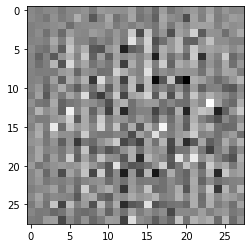

In [26]:
plt.imshow(generated_image[0,:,:,0], cmap='gray');

In [27]:
def build_discriminator():
    network = tf.keras.Sequential()

    # 14x14x64
    network.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
    network.add(layers.LeakyReLU())
    network.add(layers.Dropout(0.3))

    # 7x7x128
    network.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    network.add(layers.LeakyReLU())
    network.add(layers.Dropout(0.3))

    network.add(layers.Flatten())
    network.add(layers.Dense(1))

    network.summary()

    return network

In [28]:
7 * 7 * 128

6272

In [29]:
discriminator = build_discriminator()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [30]:
discriminator(generated_image, training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00042507]], dtype=float32)>

## Calculating the loss

- Logits: https://deepai.org/machine-learning-glossary-and-terms/logit

In [31]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [32]:
def discriminator_loss(expected_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [33]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [34]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

## Training the model

In [35]:
X_train

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

In [36]:
epochs = 100
noise_dim = 100
num_images_to_generate = 16

In [37]:
batch_size, noise_dim

(256, 100)

In [38]:
@tf.function
def train_steps(images):
    noise = tf.random.normal([batch_size, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training = True)

    expected_output = discriminator(images, training = True)
    fake_output = discriminator(generated_images, training = True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(expected_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [39]:
test_images = tf.random.normal([num_images_to_generate, noise_dim])

In [40]:
test_images.shape

TensorShape([16, 100])

In [41]:
60000 / 256

234.375

In [42]:
def train(dataset, epochs, test_images):
    for epoch in range(epochs):
        for image_batch in dataset:
          #print(image_batch.shape)
          train_steps(image_batch)

        print('Epoch: ', epoch + 1)
        generated_images = generator(test_images, training = False)
        fig = plt.figure(figsize=(10,10))
        for i in range(generated_images.shape[0]):
            plt.subplot(4,4,i+1)
            plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')
        plt.show()

Epoch:  1


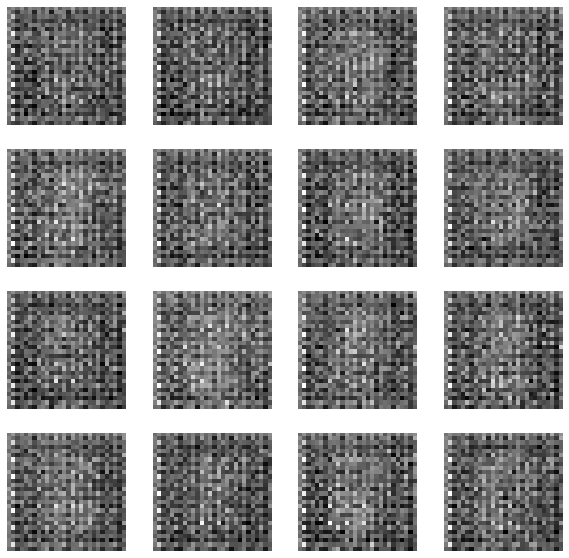

Epoch:  2


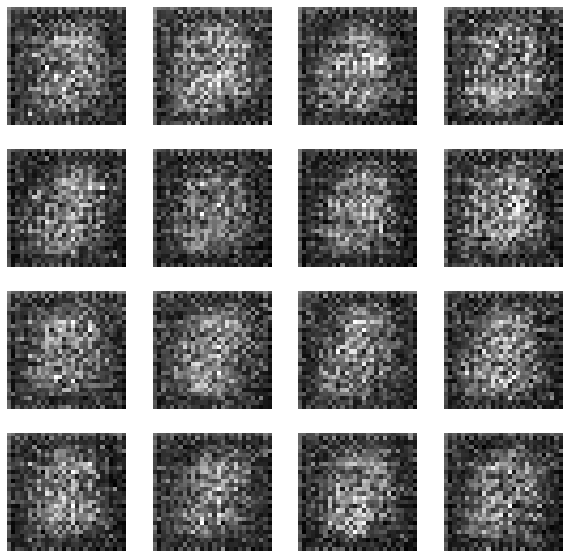

Epoch:  3


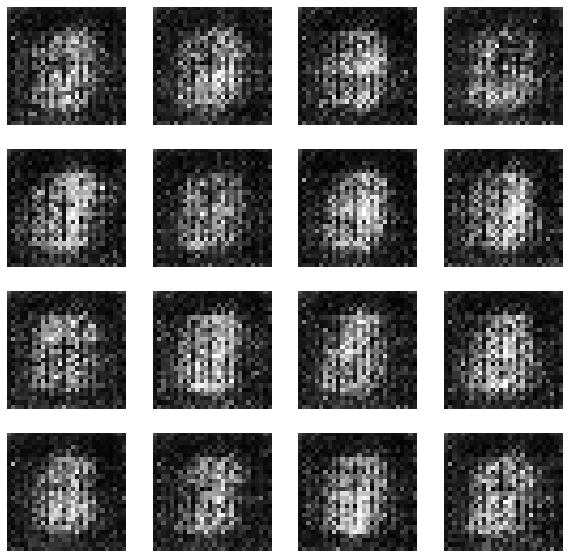

Epoch:  4


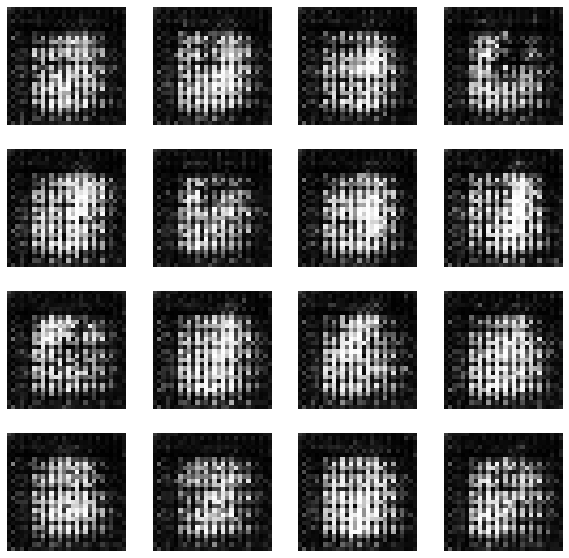

Epoch:  5


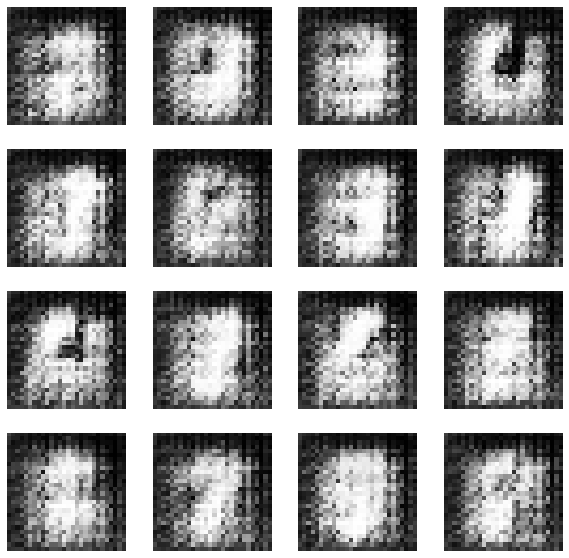

Epoch:  6


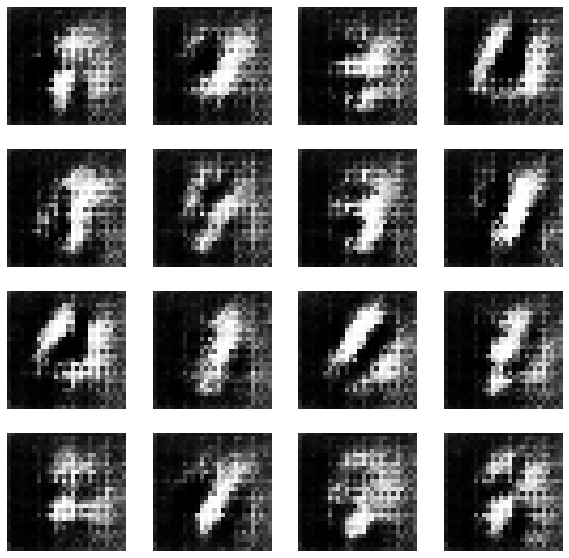

Epoch:  7


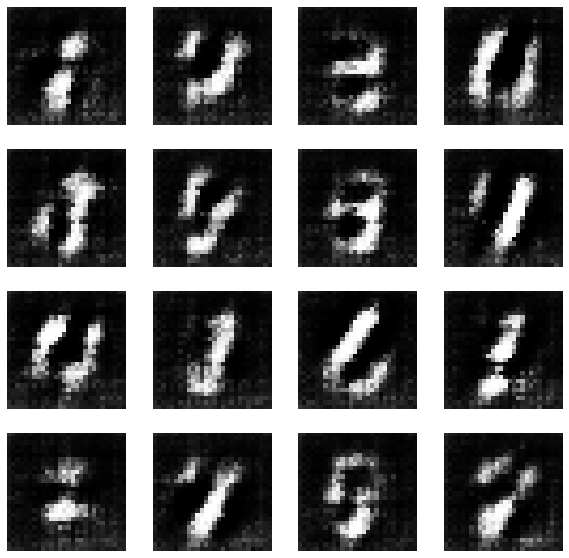

Epoch:  8


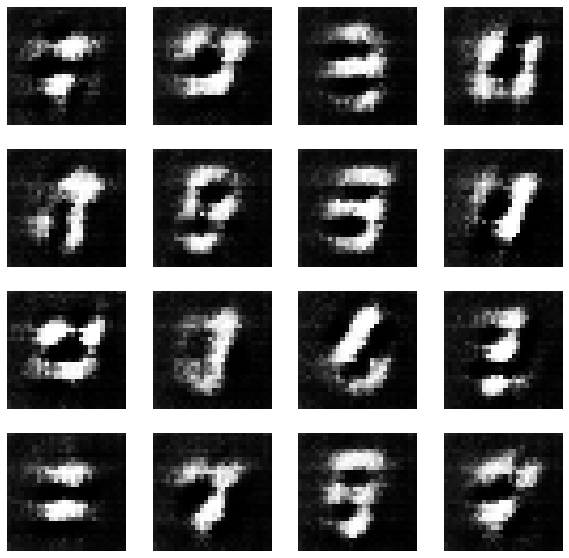

Epoch:  9


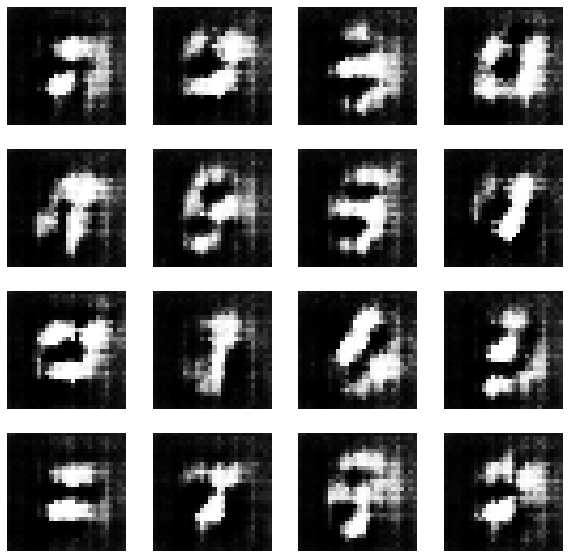

Epoch:  10


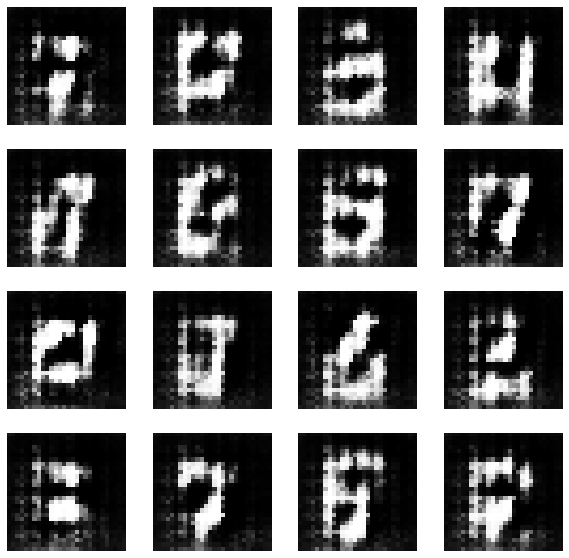

Epoch:  11


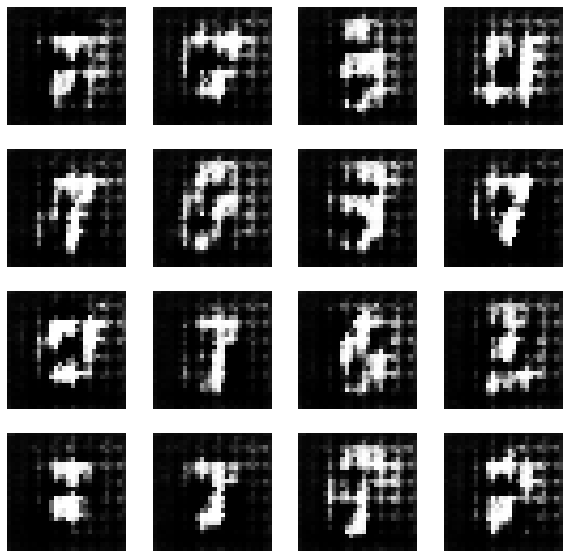

Epoch:  12


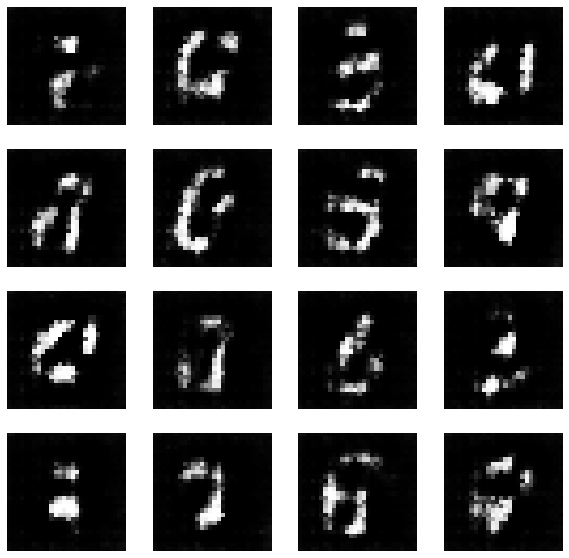

Epoch:  13


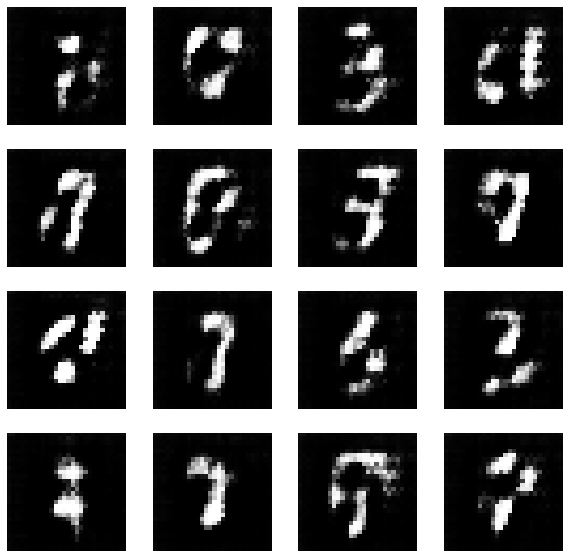

Epoch:  14


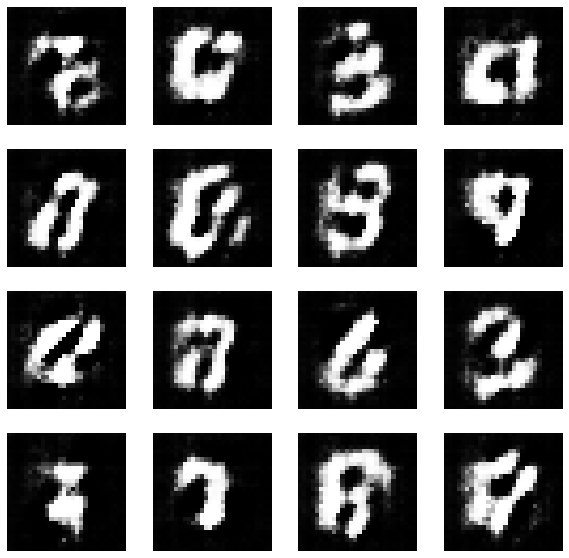

Epoch:  15


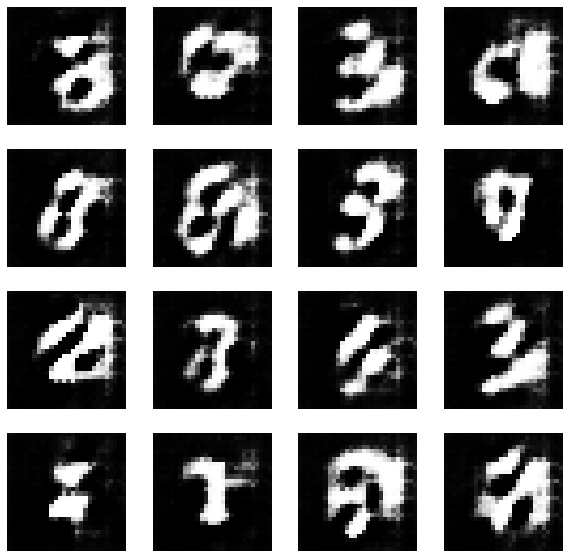

Epoch:  16


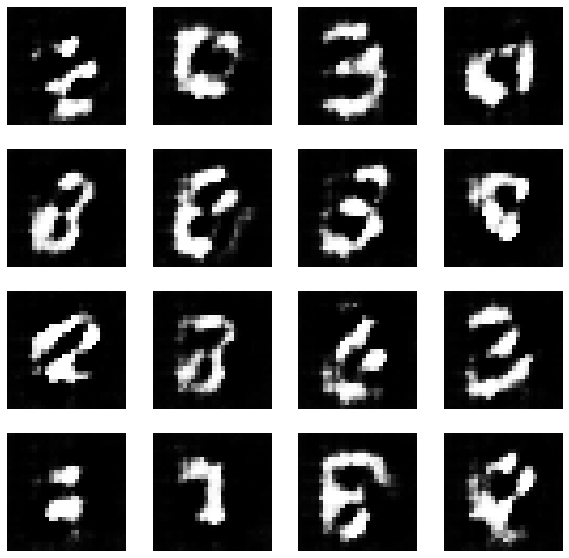

Epoch:  17


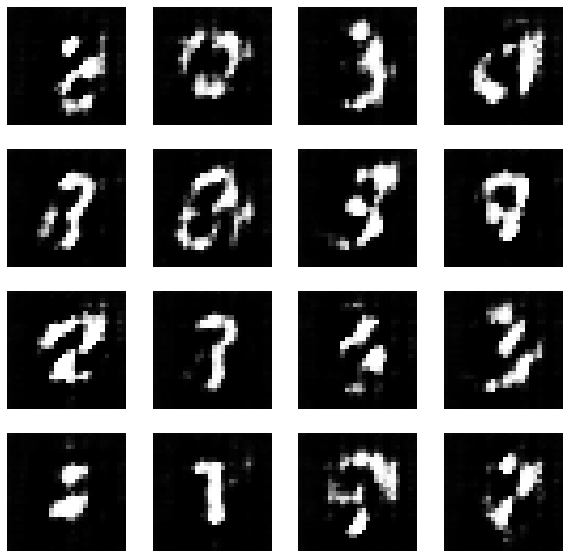

Epoch:  18


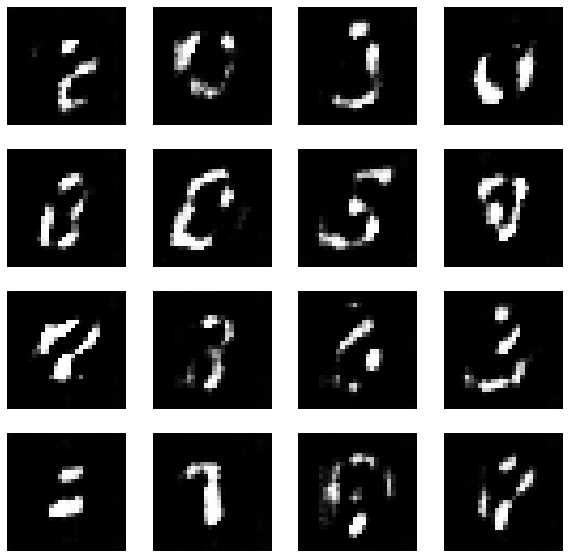

Epoch:  19


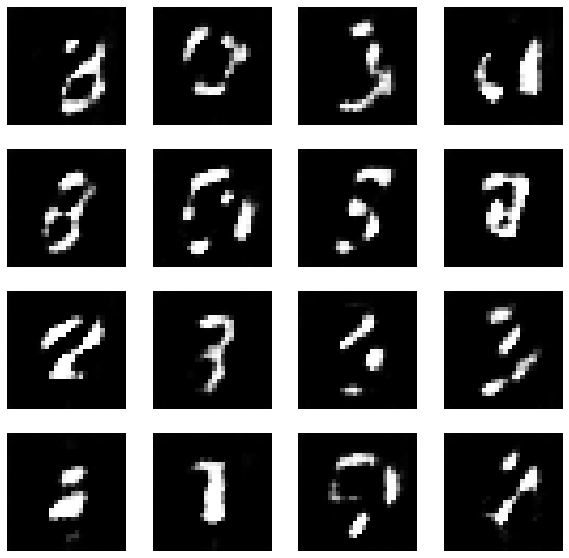

Epoch:  20


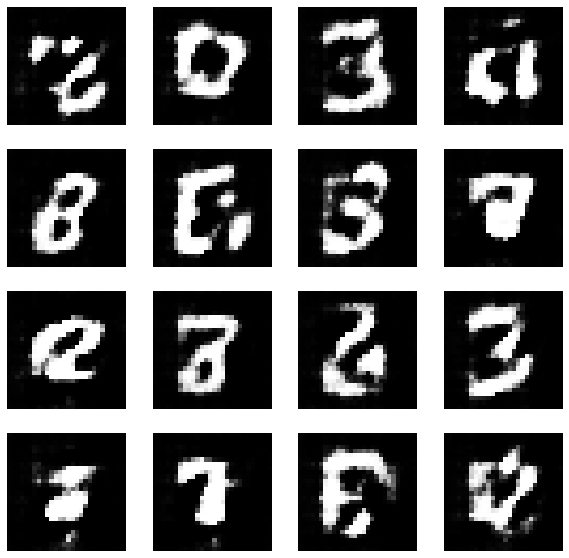

Epoch:  21


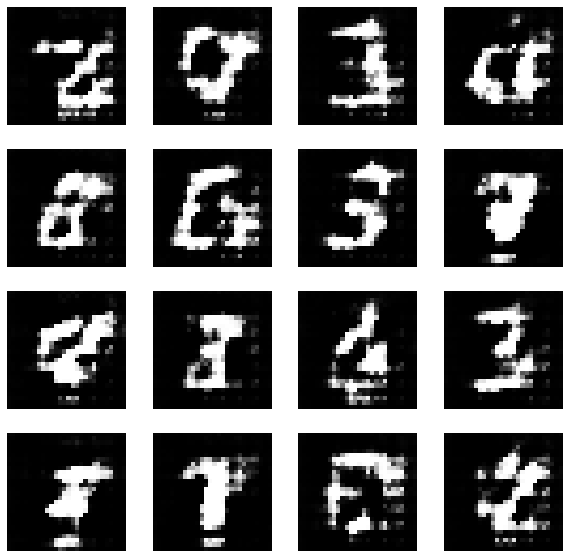

Epoch:  22


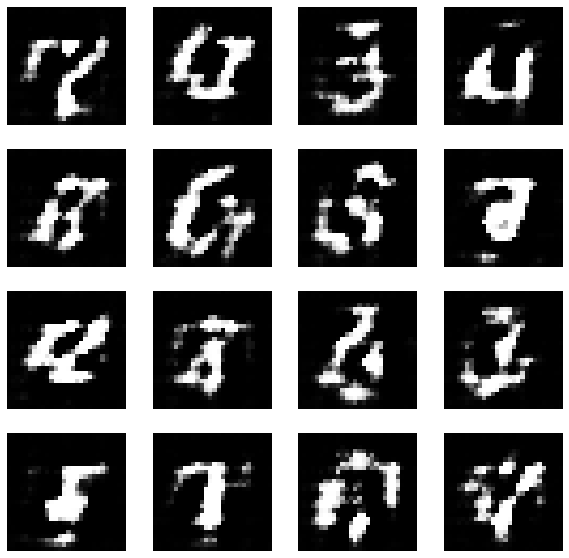

Epoch:  23


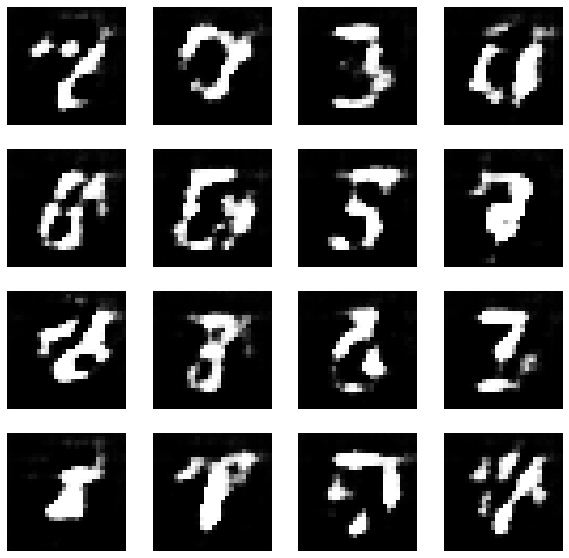

Epoch:  24


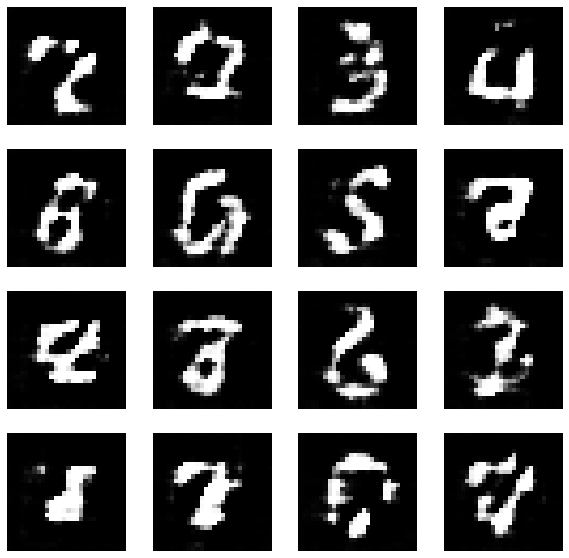

Epoch:  25


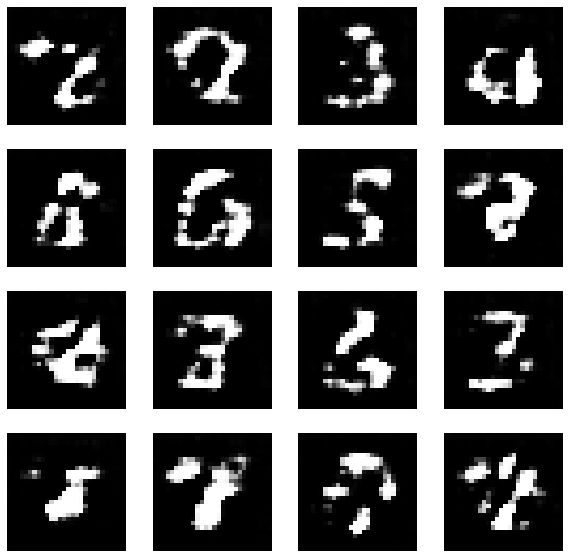

Epoch:  26


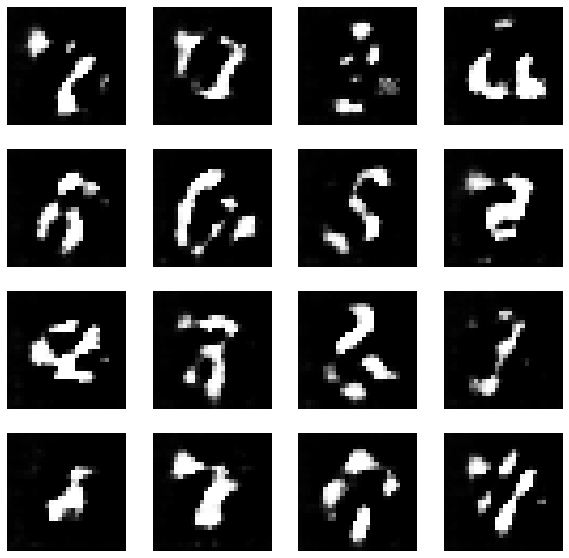

Epoch:  27


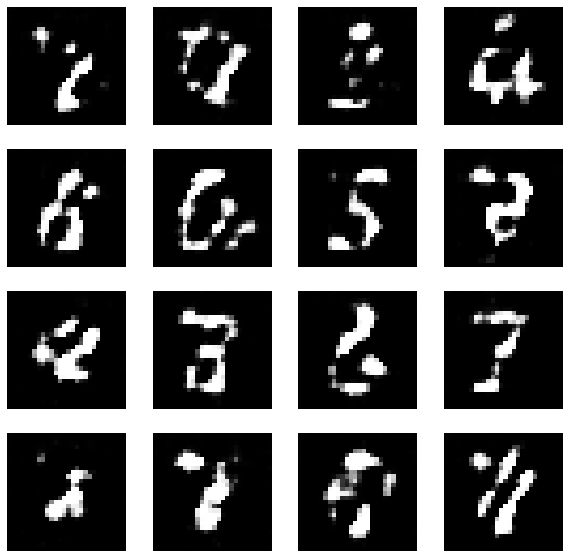

Epoch:  28


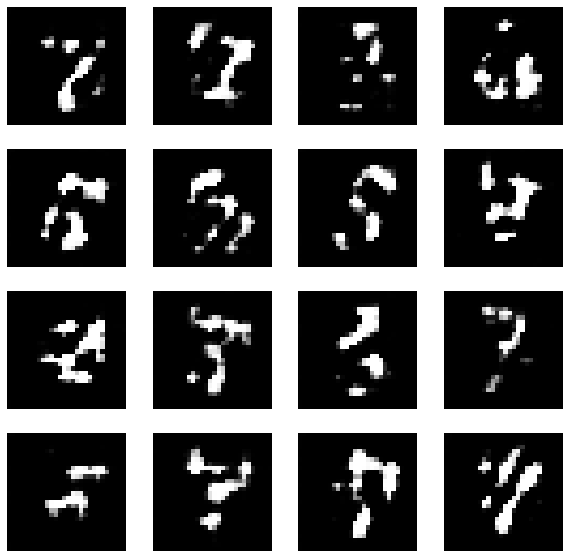

Epoch:  29


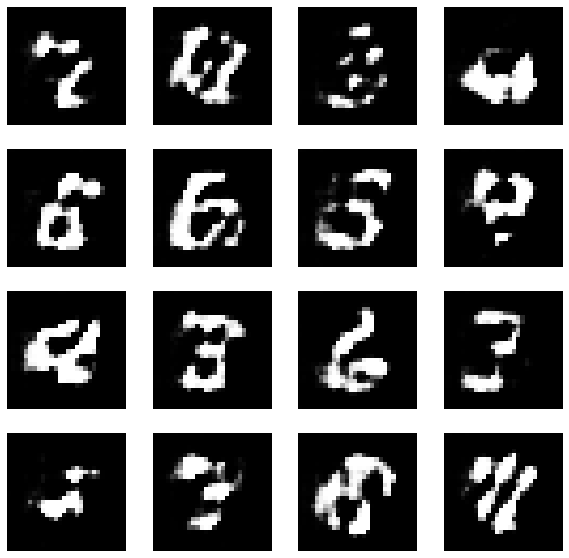

Epoch:  30


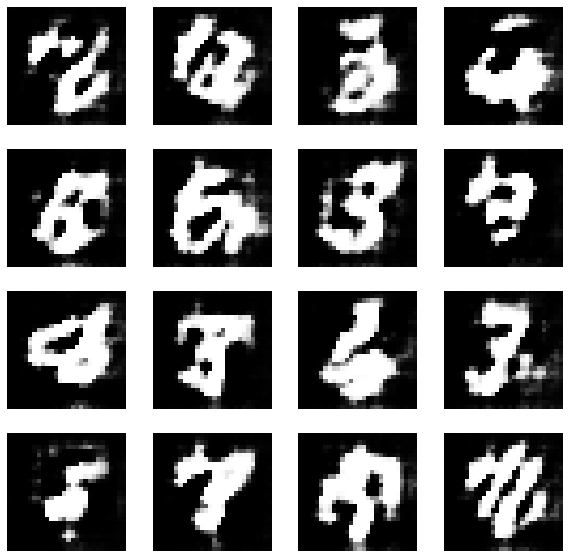

Epoch:  31


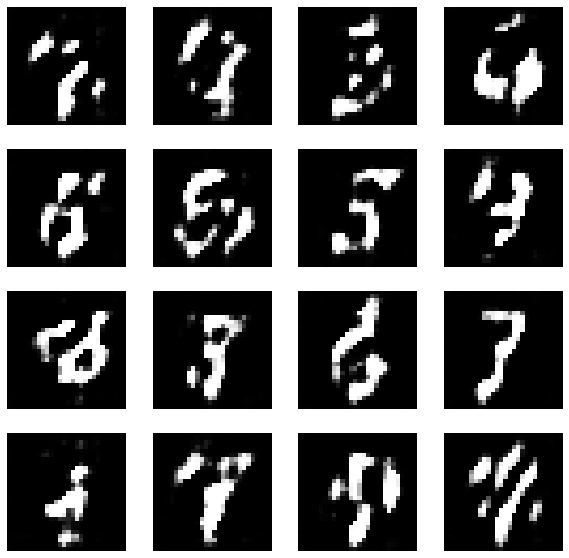

Epoch:  32


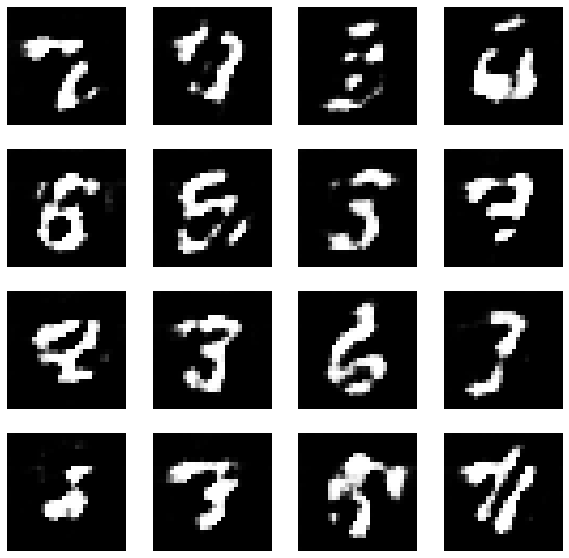

Epoch:  33


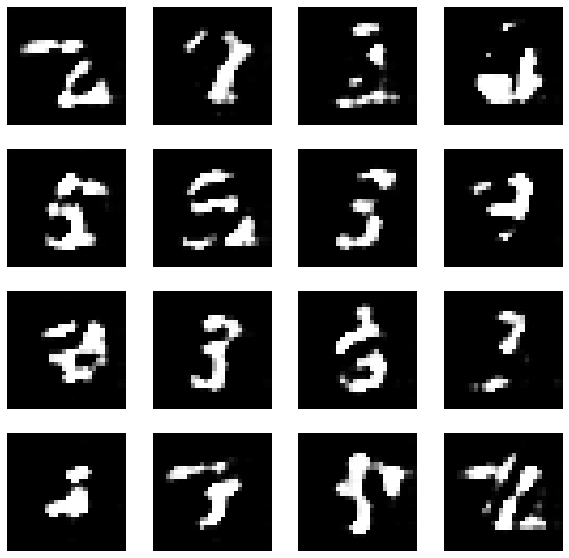

Epoch:  34


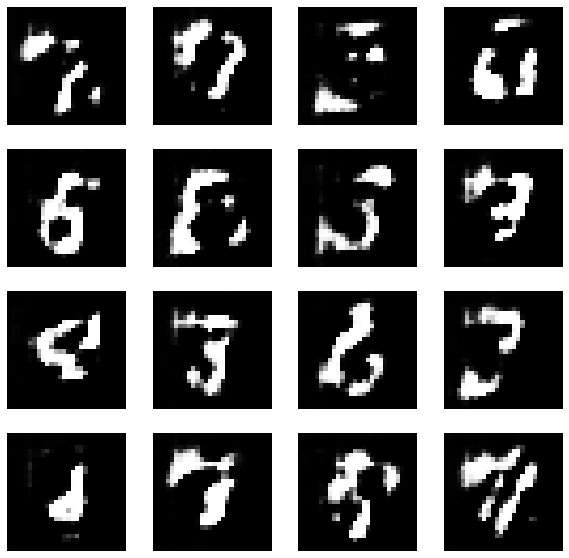

Epoch:  35


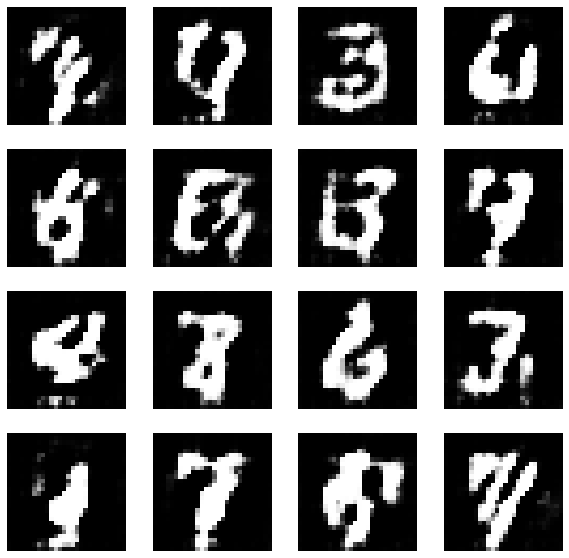

Epoch:  36


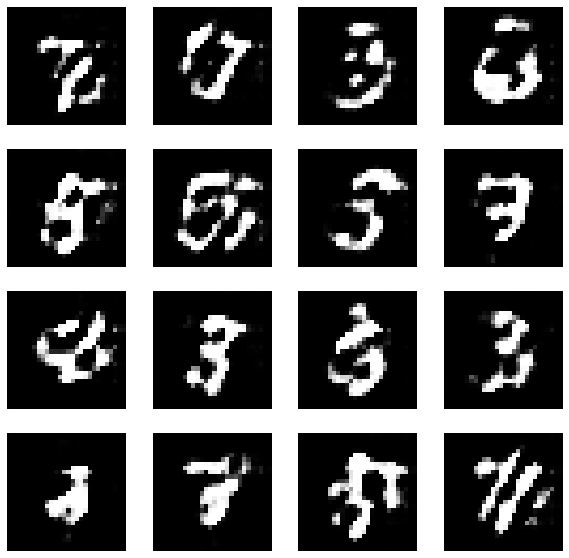

Epoch:  37


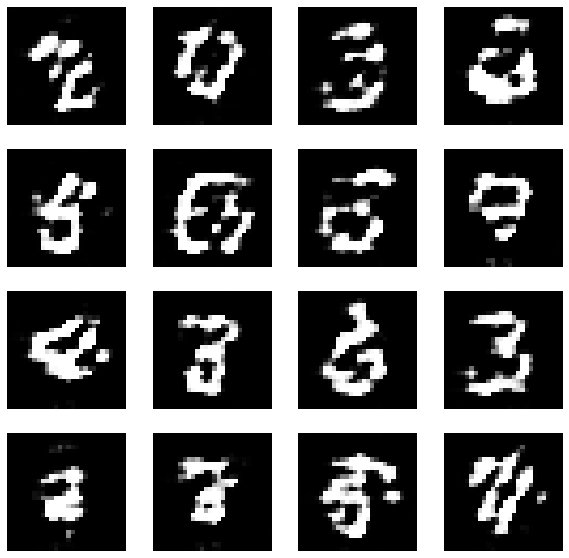

Epoch:  38


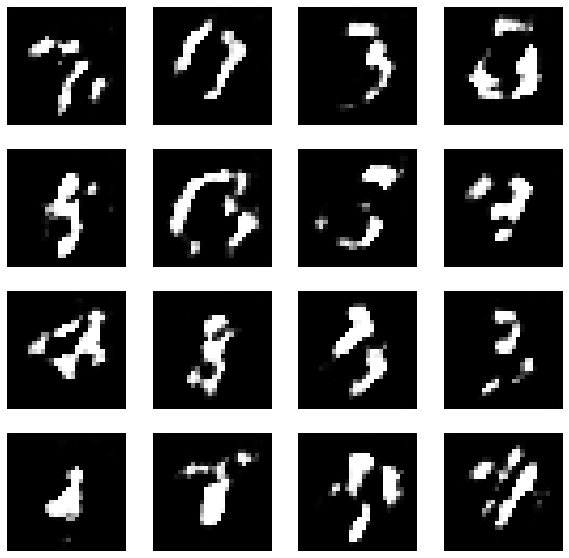

Epoch:  39


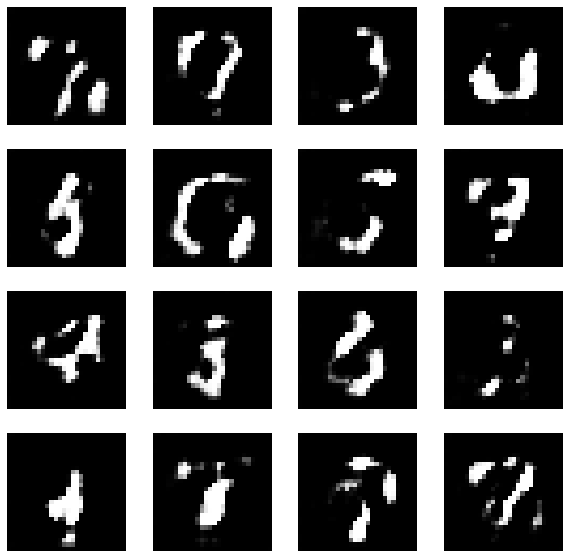

Epoch:  40


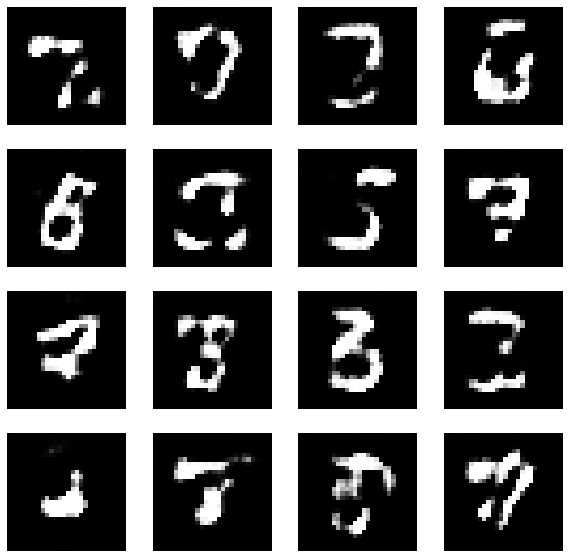

Epoch:  41


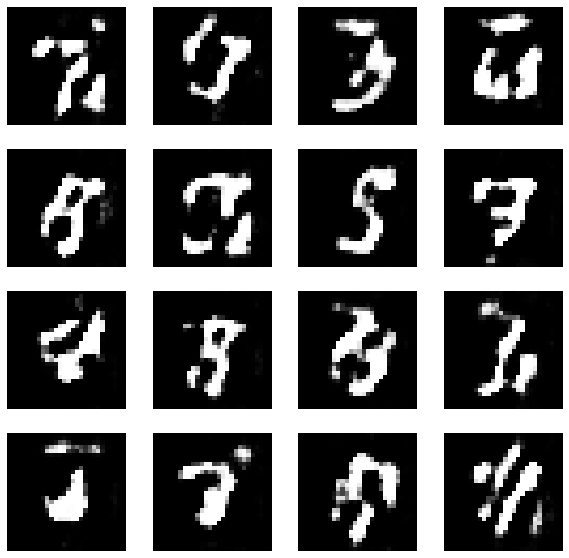

Epoch:  42


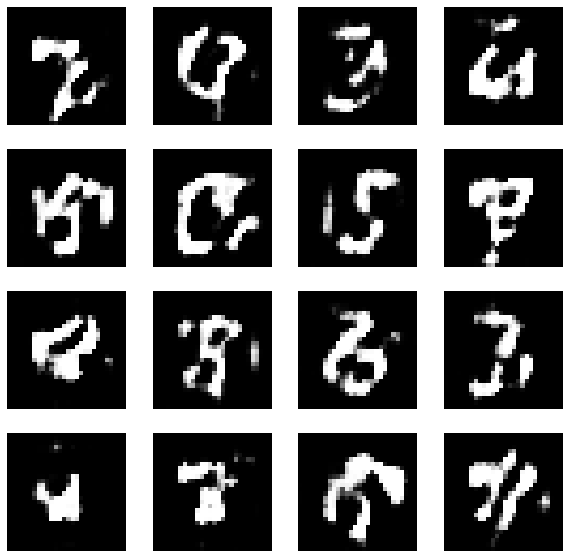

Epoch:  43


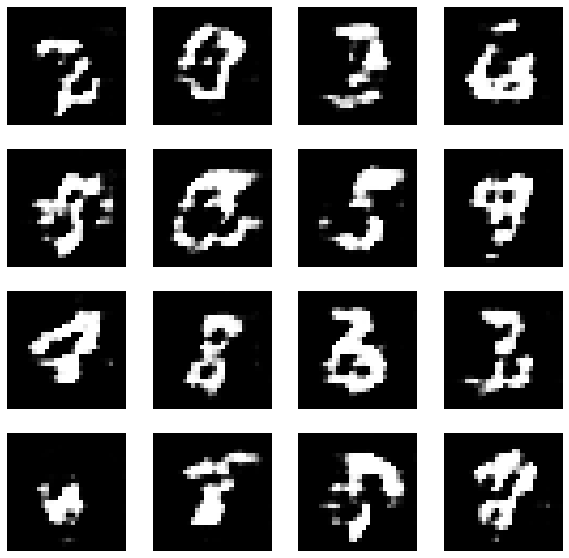

Epoch:  44


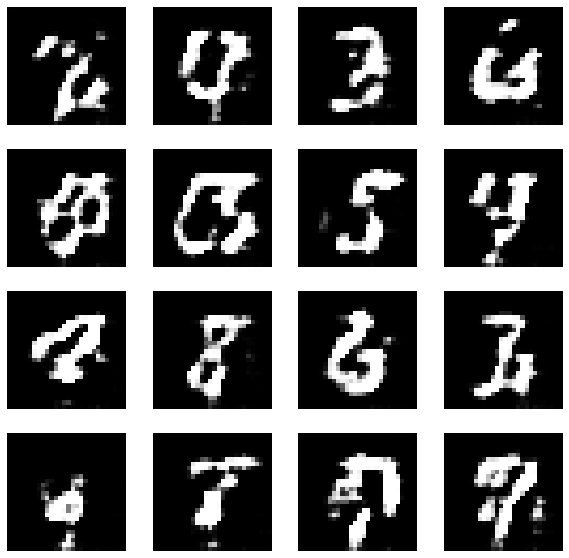

Epoch:  45


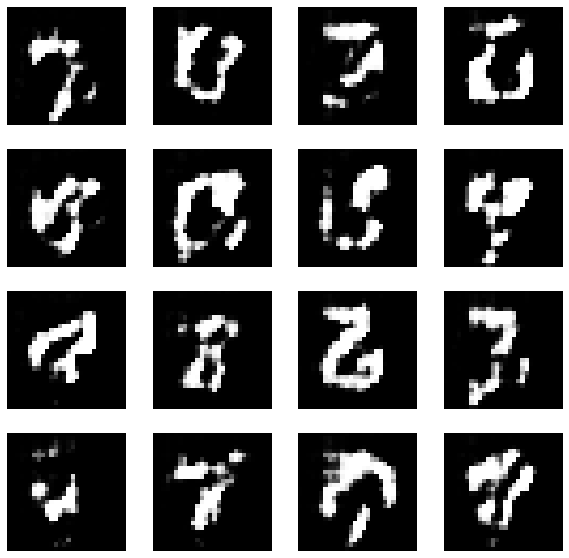

Epoch:  46


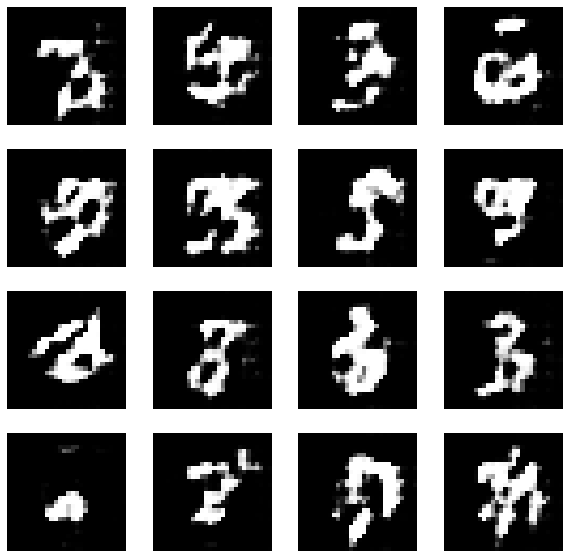

Epoch:  47


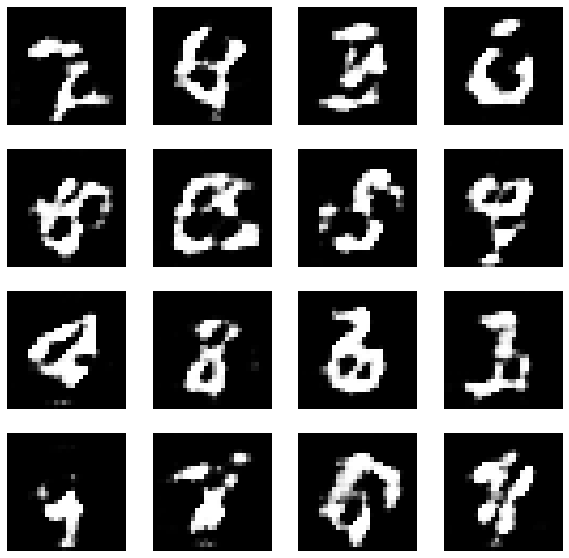

Epoch:  48


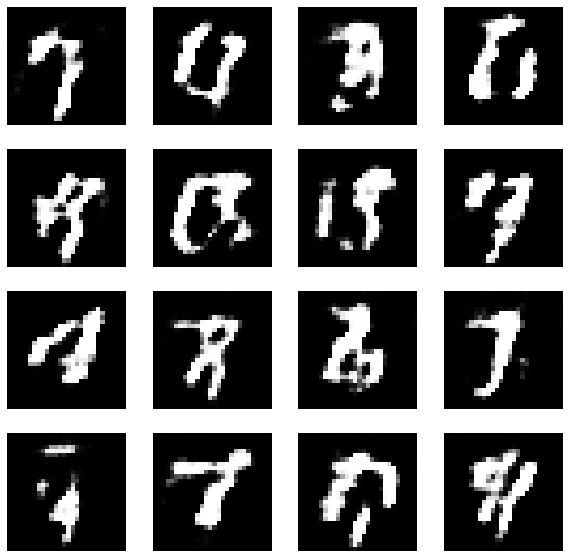

Epoch:  49


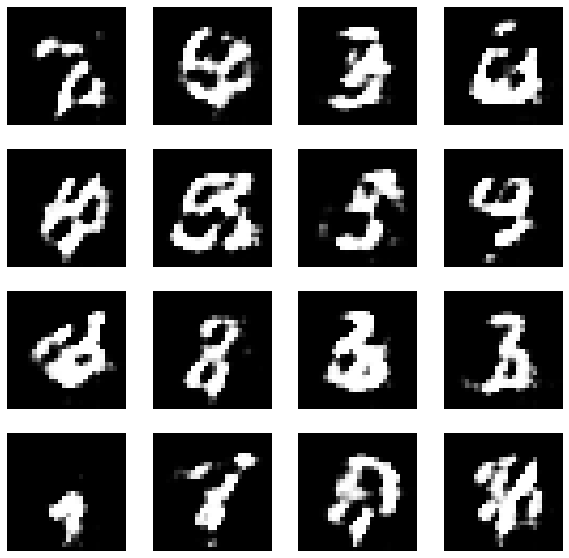

Epoch:  50


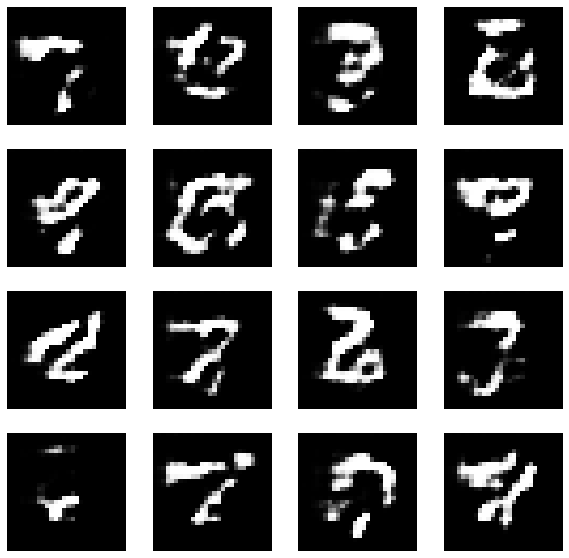

Epoch:  51


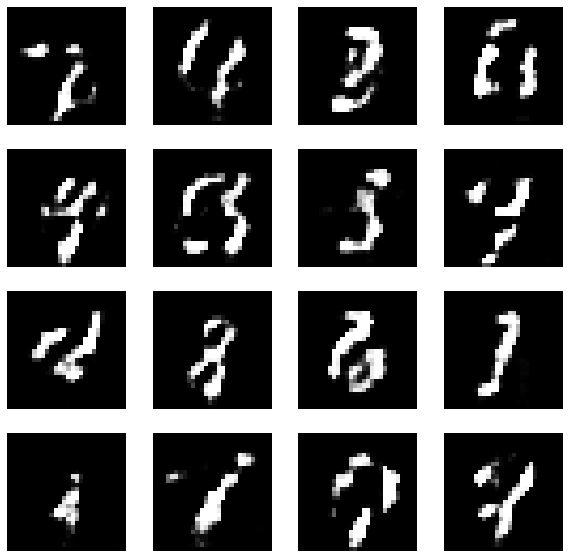

Epoch:  52


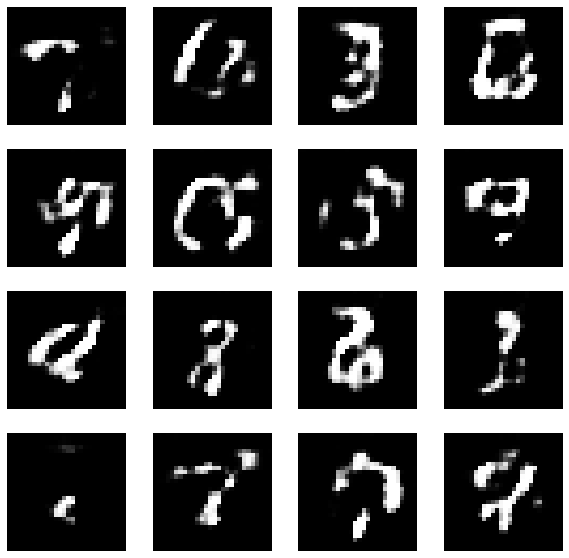

Epoch:  53


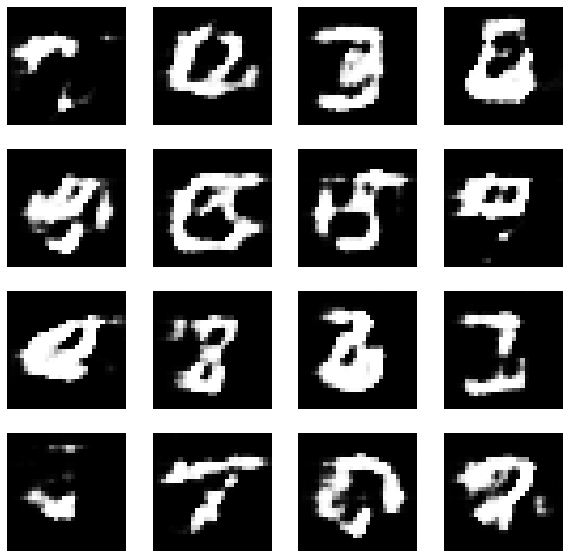

Epoch:  54


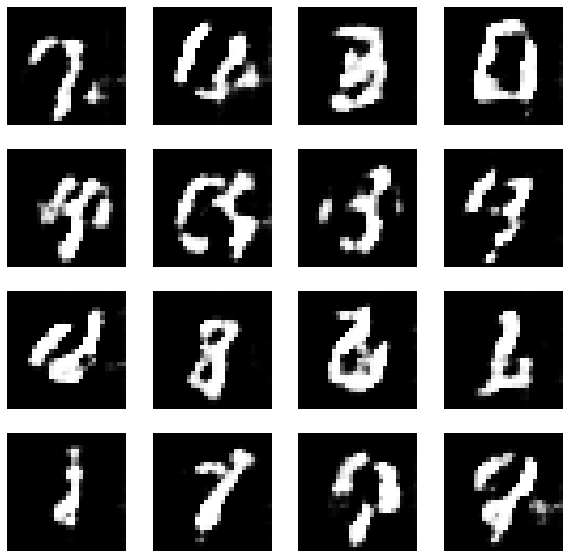

Epoch:  55


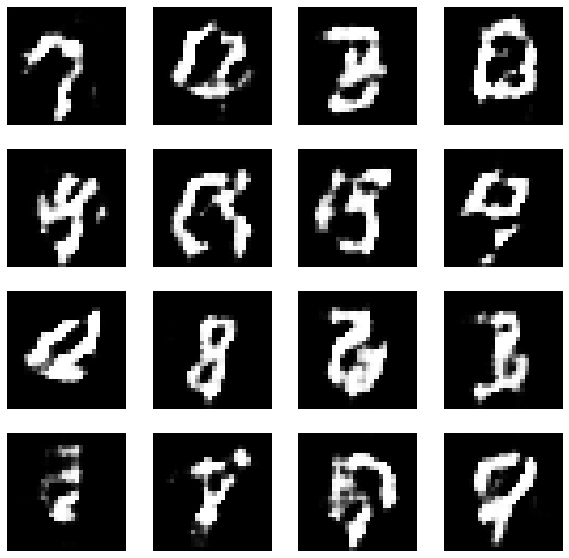

Epoch:  56


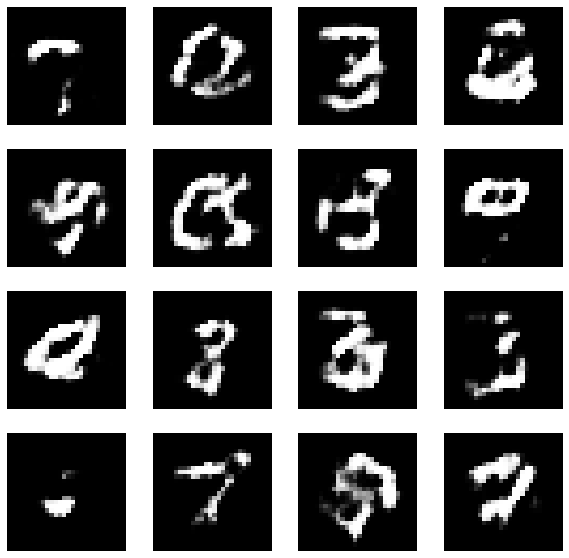

Epoch:  57


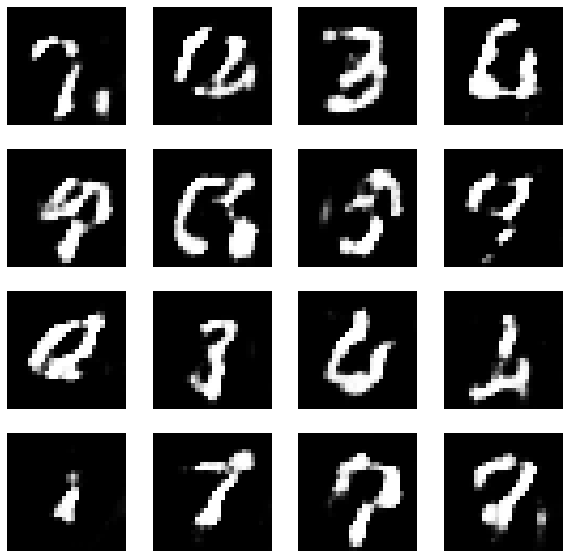

Epoch:  58


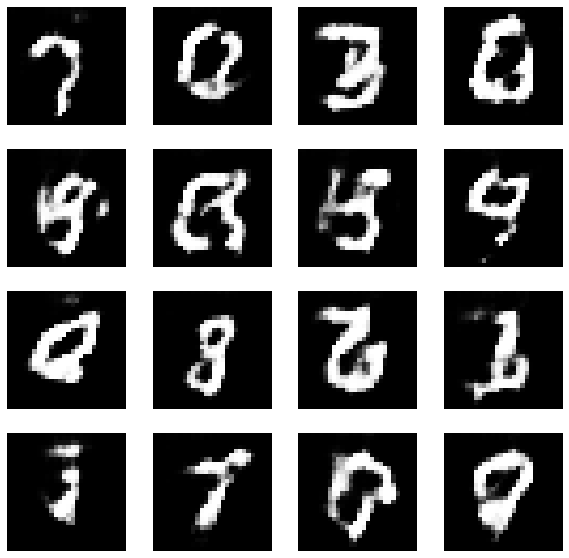

Epoch:  59


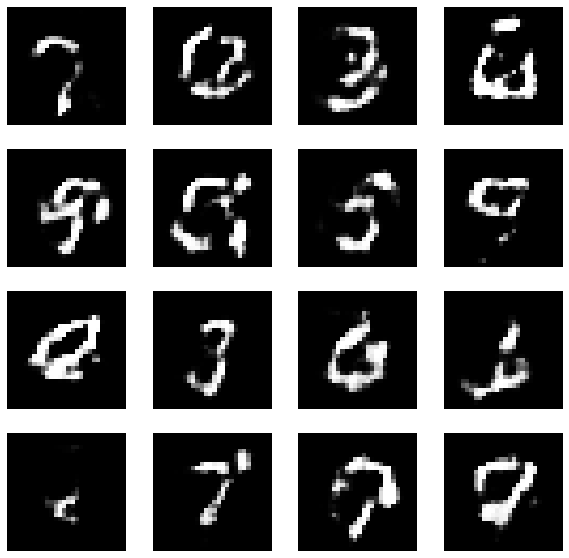

Epoch:  60


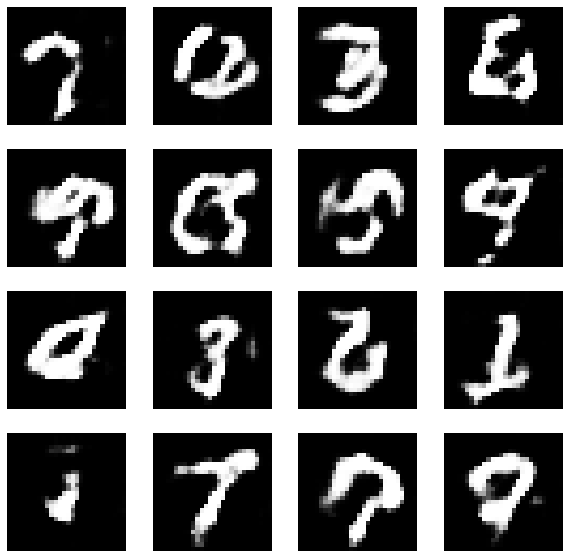

Epoch:  61


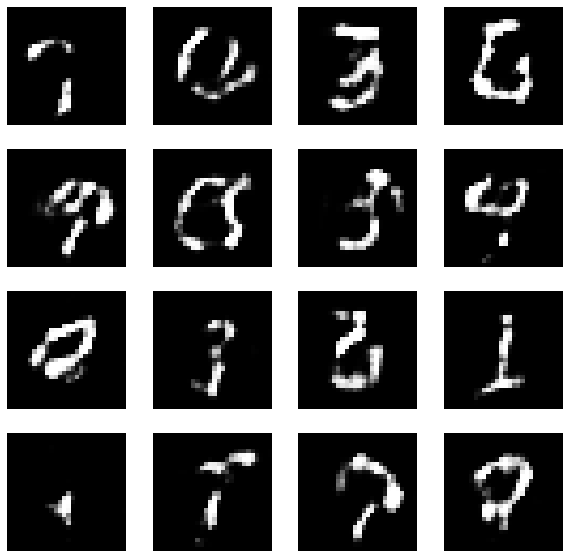

Epoch:  62


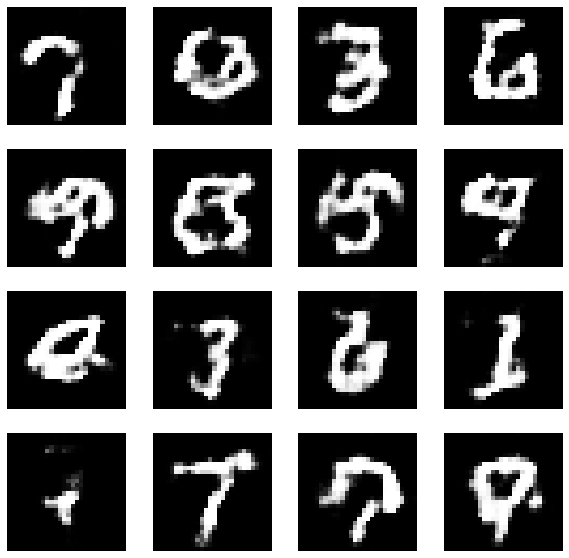

Epoch:  63


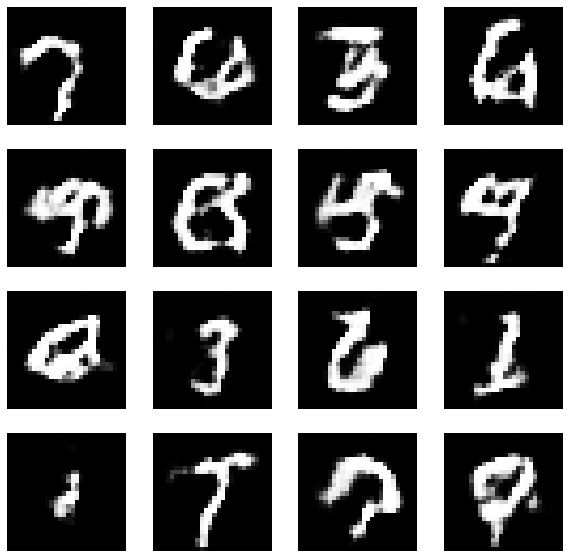

Epoch:  64


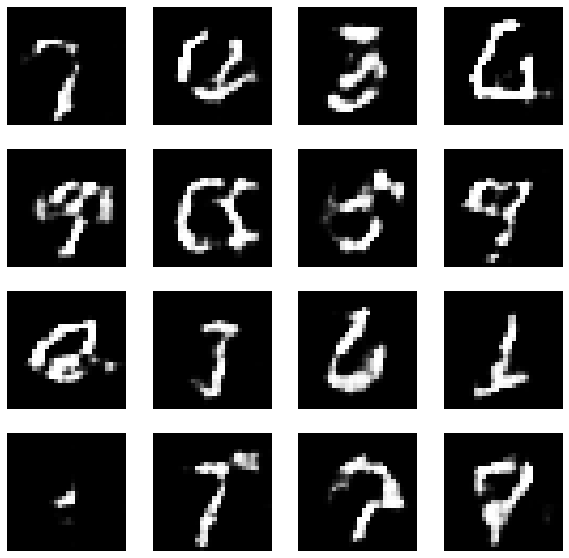

Epoch:  65


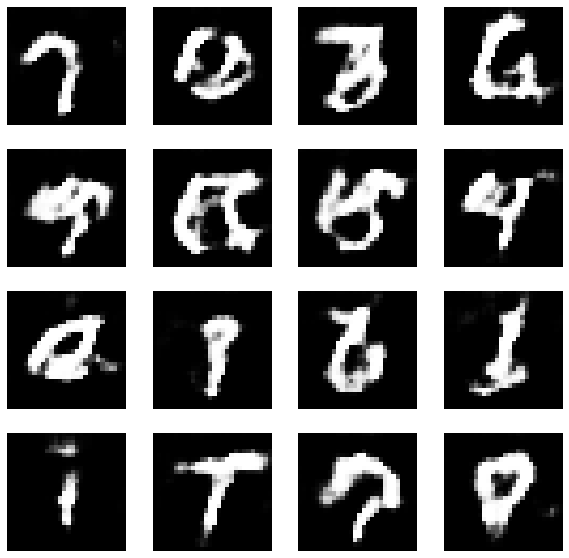

Epoch:  66


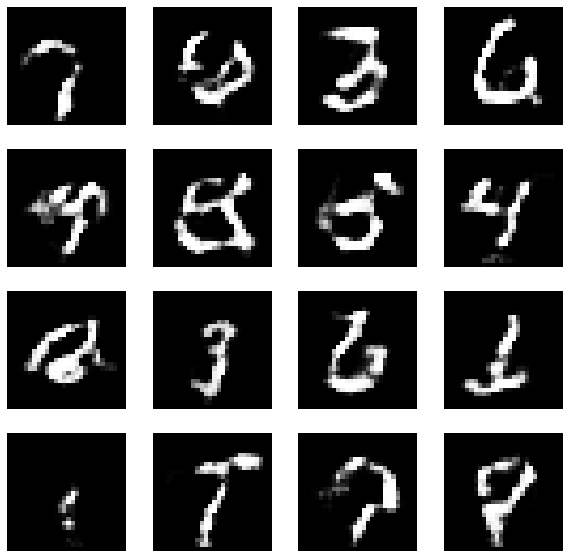

Epoch:  67


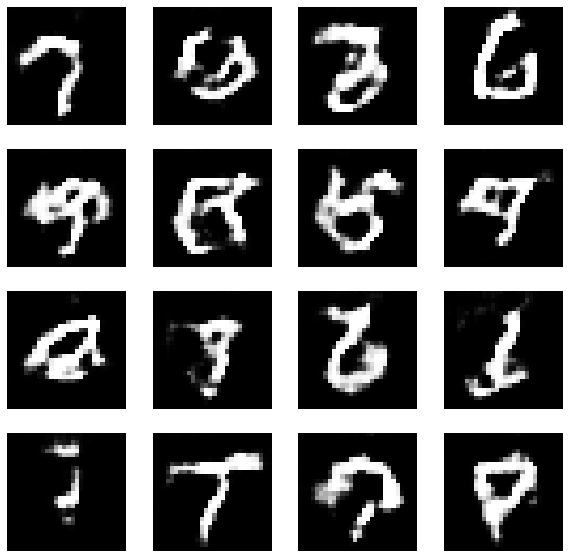

Epoch:  68


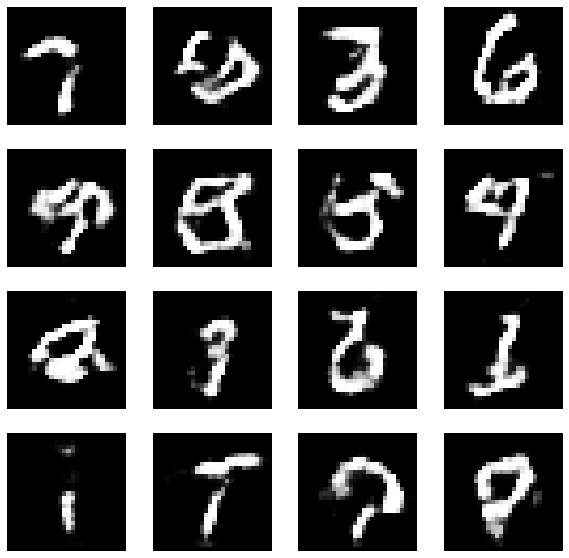

Epoch:  69


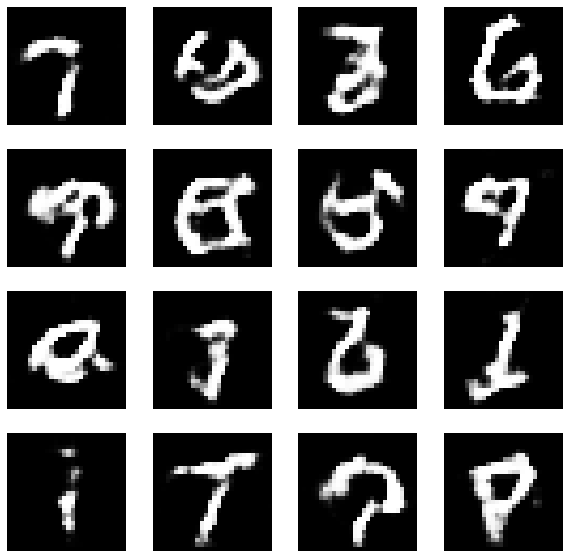

Epoch:  70


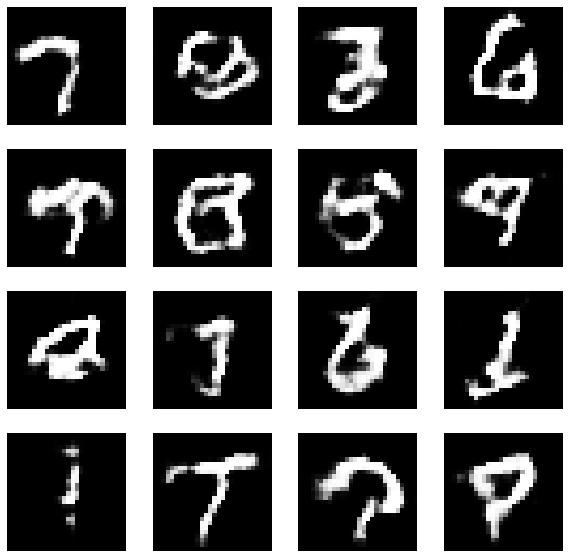

Epoch:  71


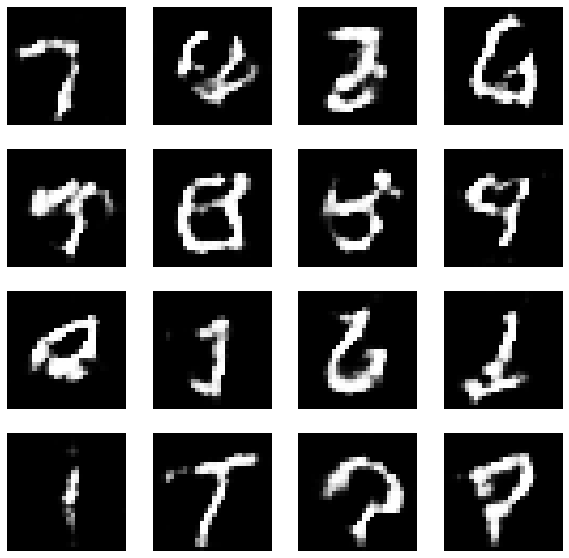

Epoch:  72


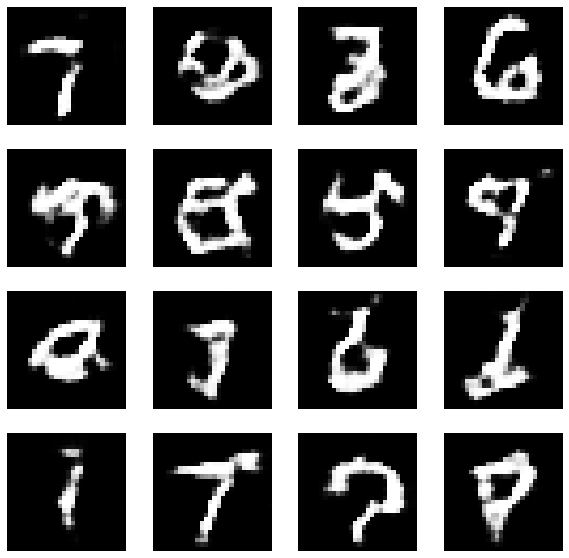

Epoch:  73


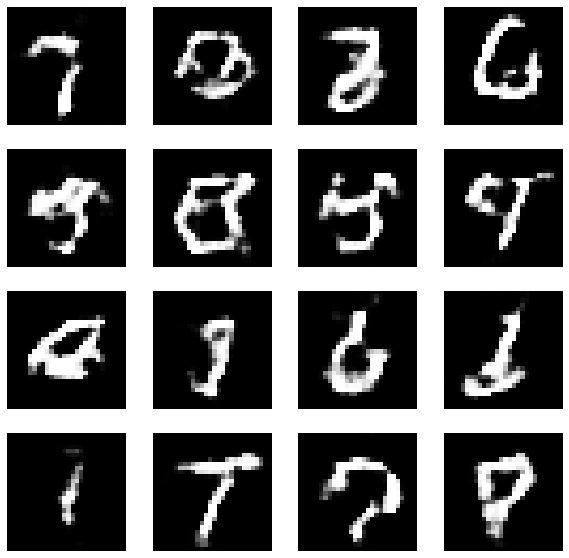

Epoch:  74


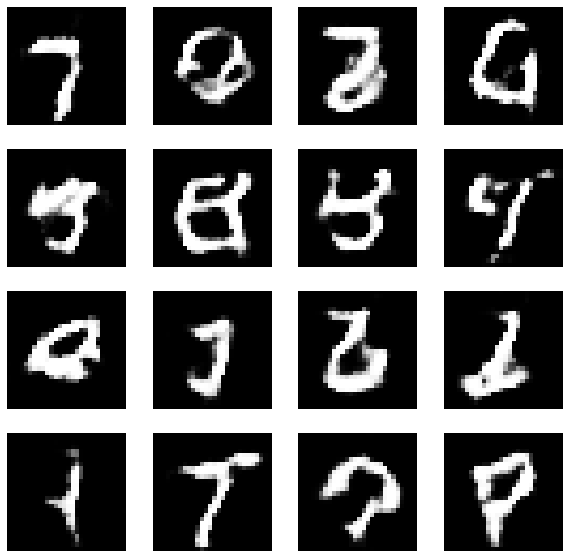

Epoch:  75


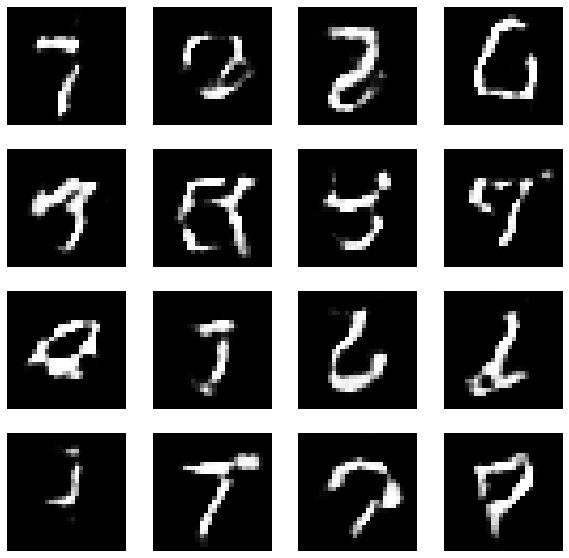

Epoch:  76


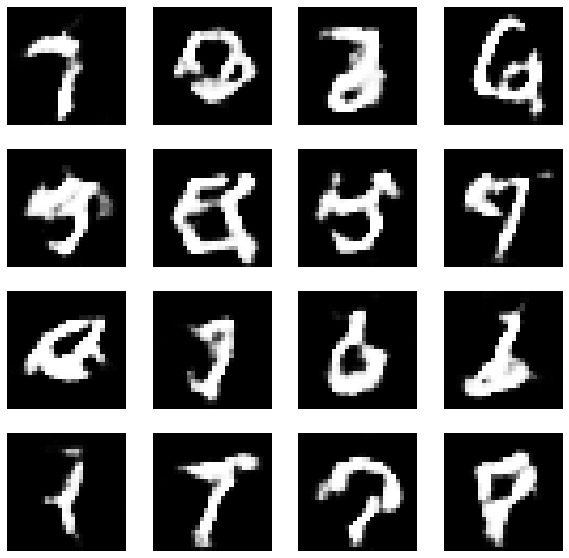

Epoch:  77


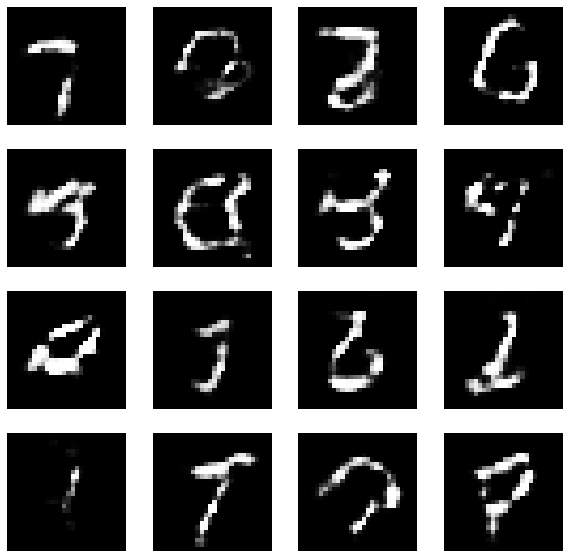

Epoch:  78


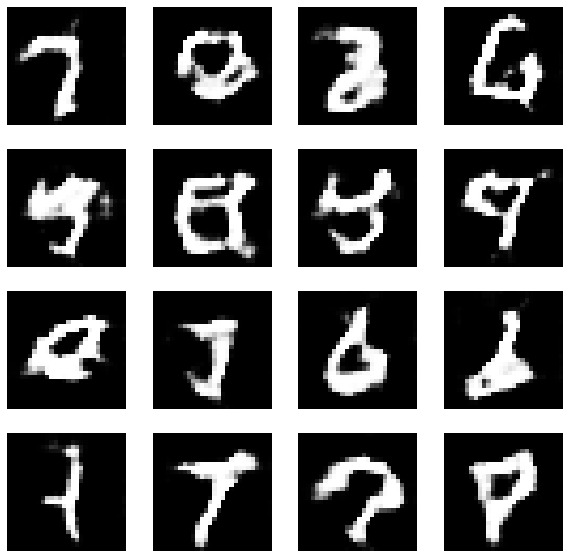

Epoch:  79


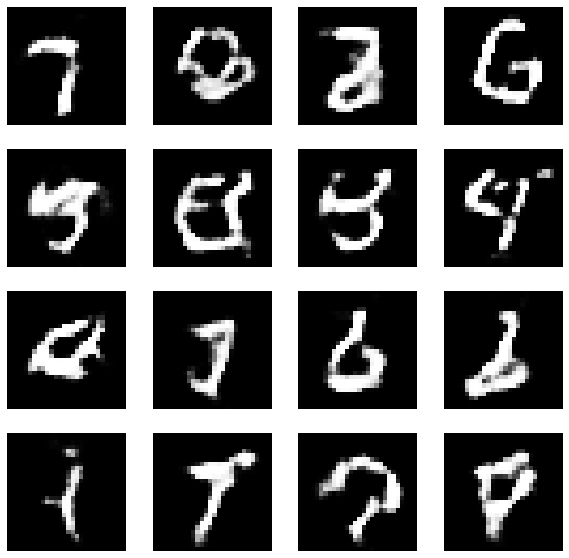

Epoch:  80


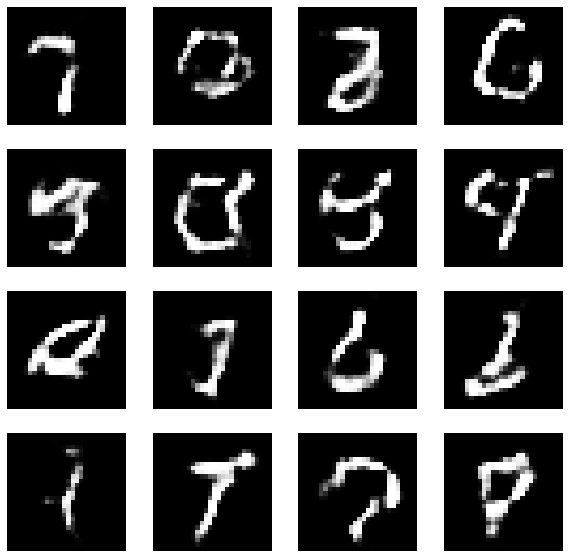

Epoch:  81


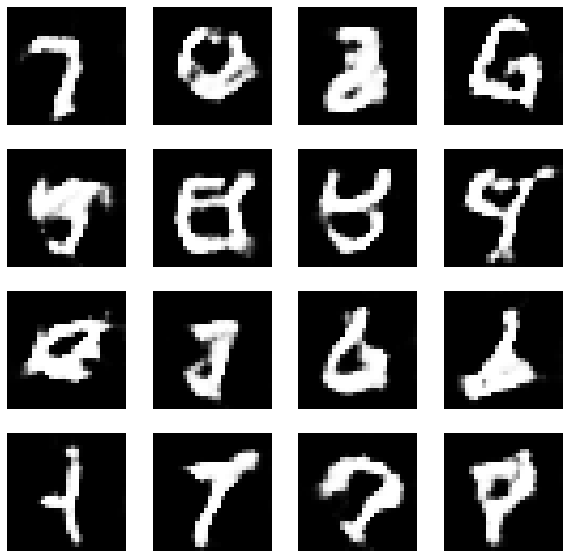

Epoch:  82


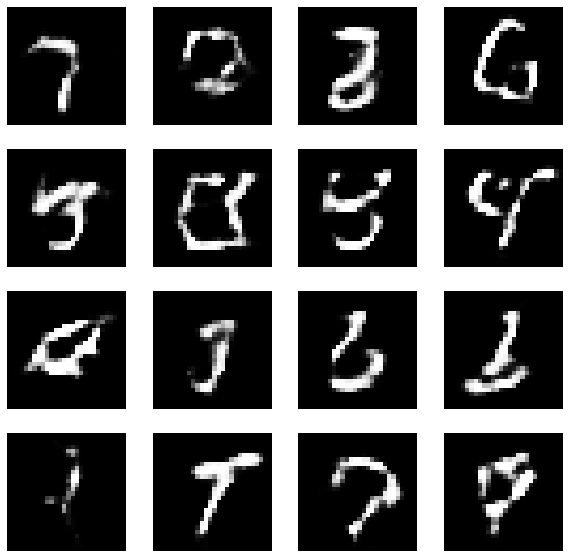

Epoch:  83


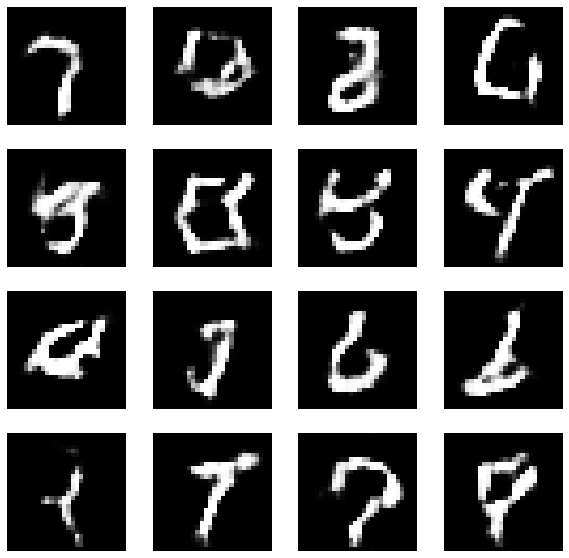

Epoch:  84


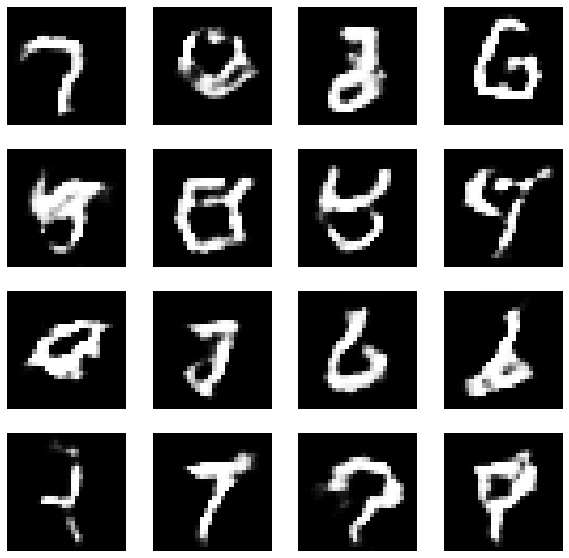

Epoch:  85


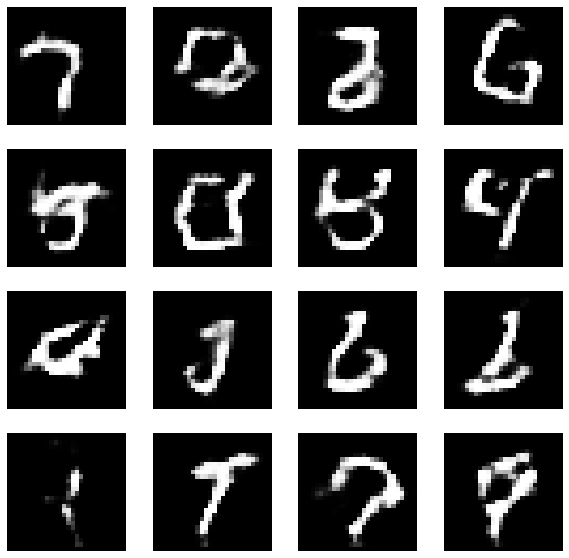

Epoch:  86


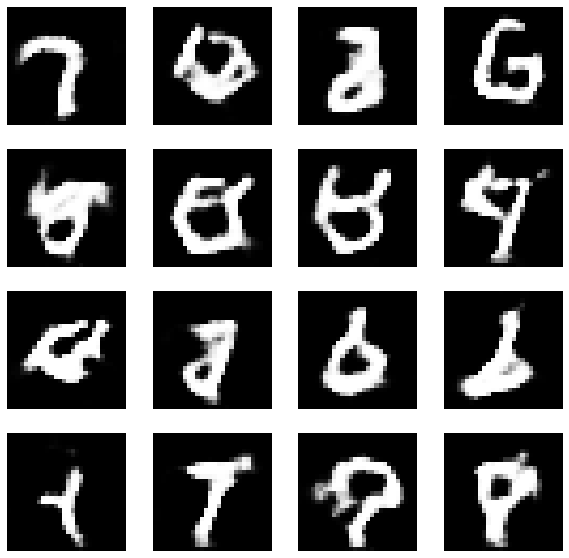

Epoch:  87


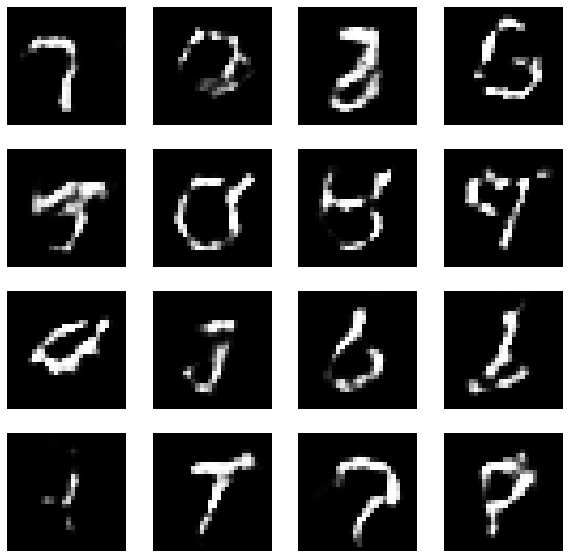

Epoch:  88


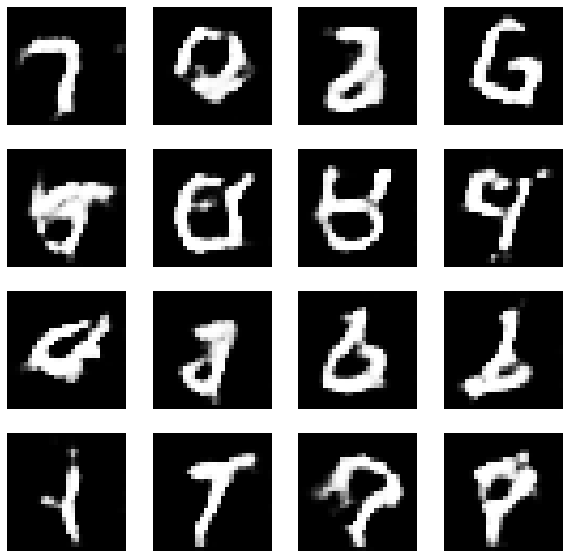

Epoch:  89


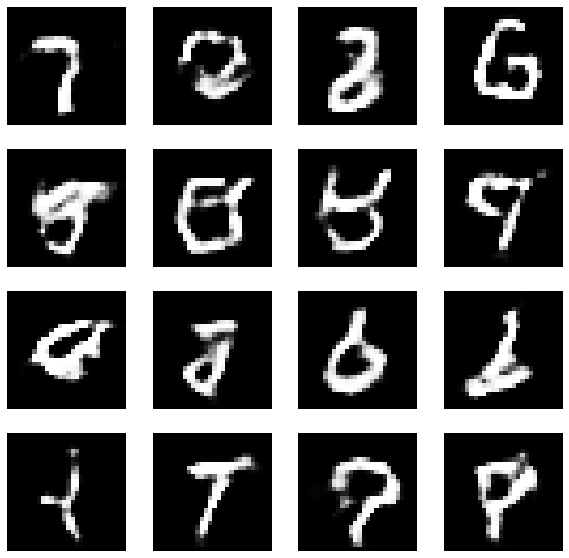

Epoch:  90


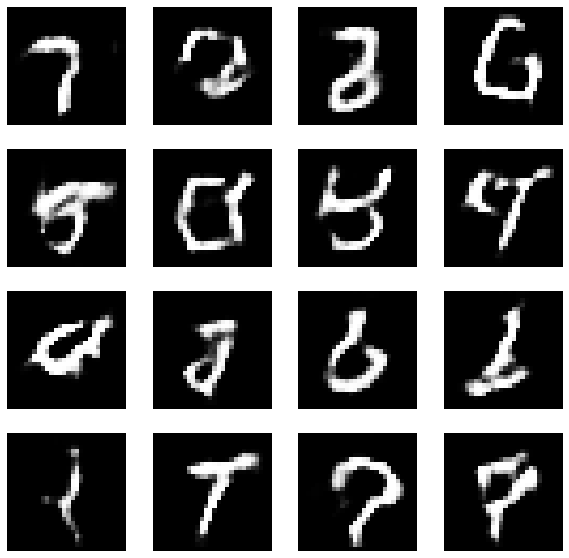

Epoch:  91


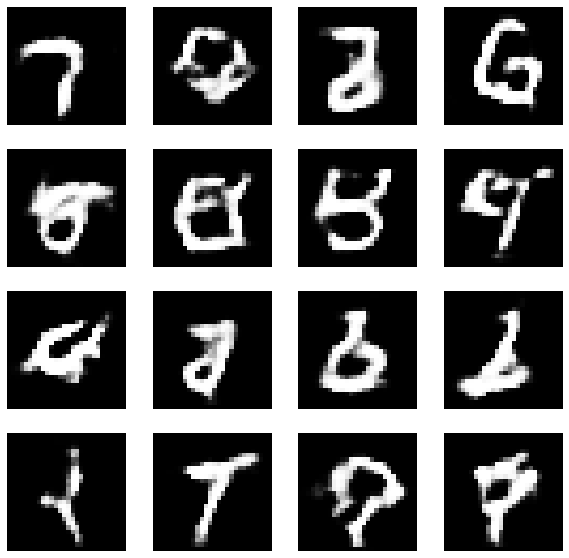

Epoch:  92


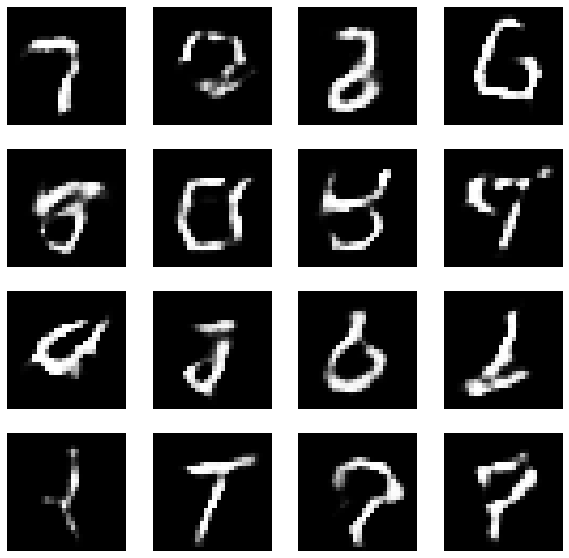

Epoch:  93


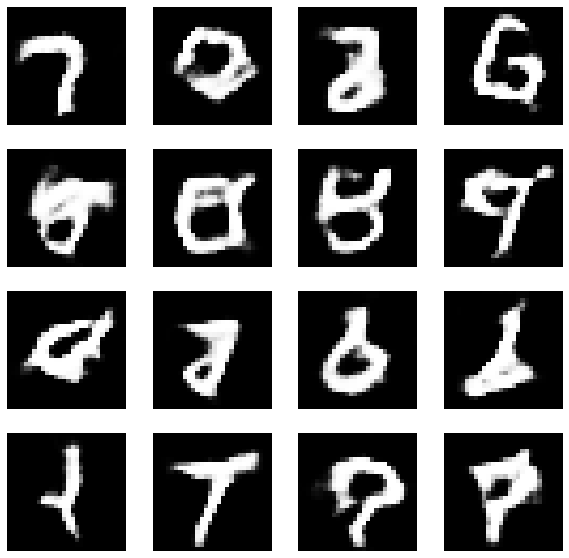

Epoch:  94


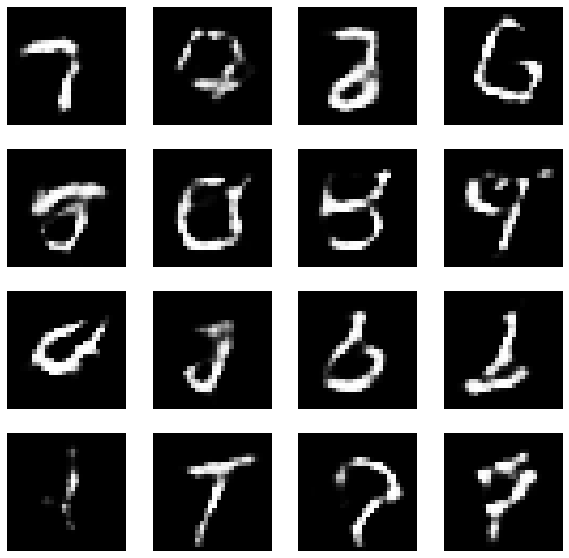

Epoch:  95


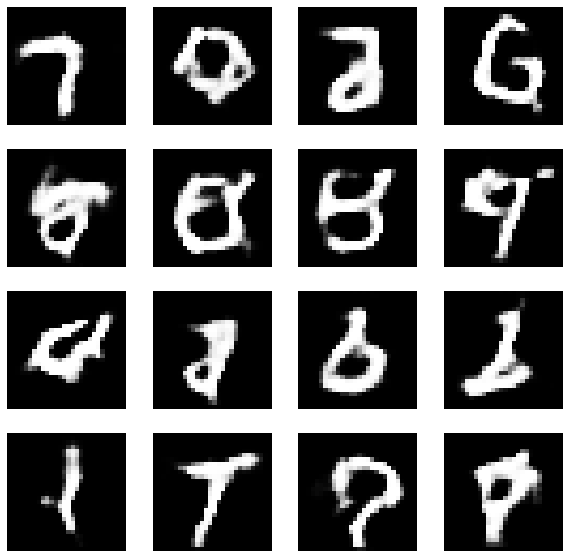

Epoch:  96


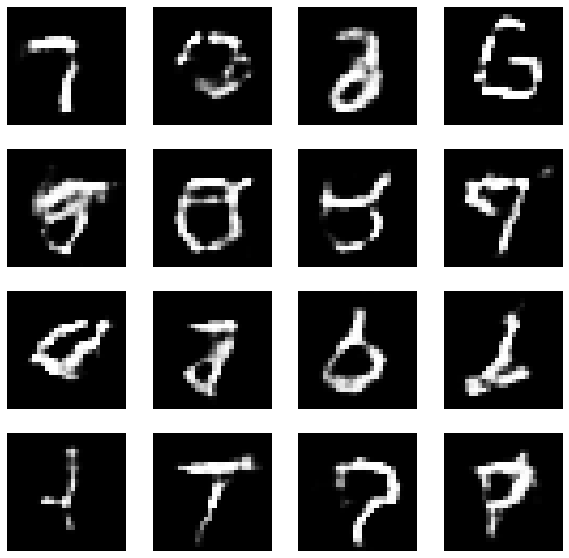

Epoch:  97


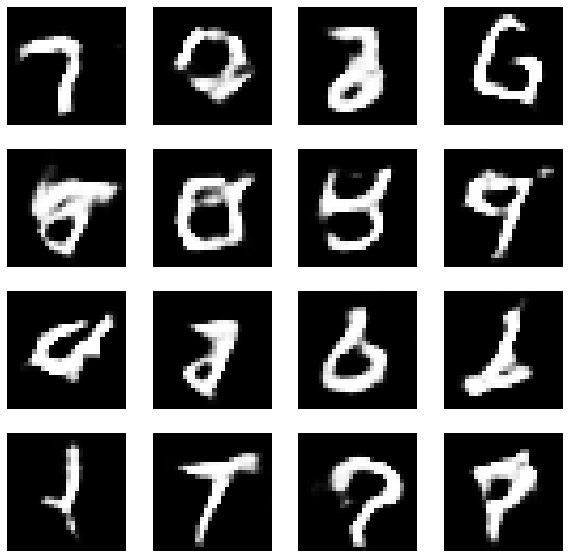

Epoch:  98


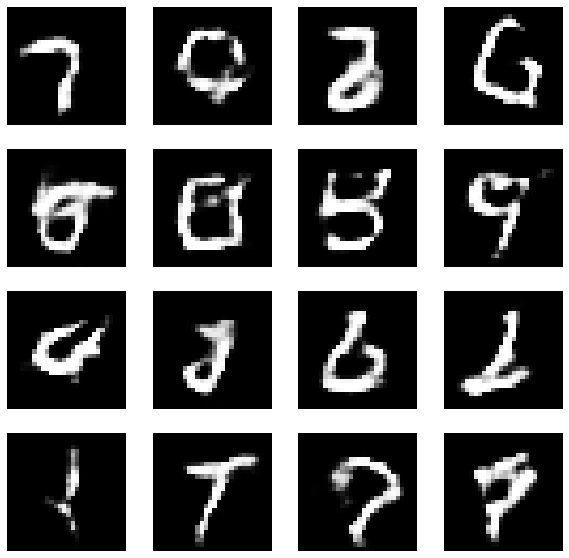

Epoch:  99


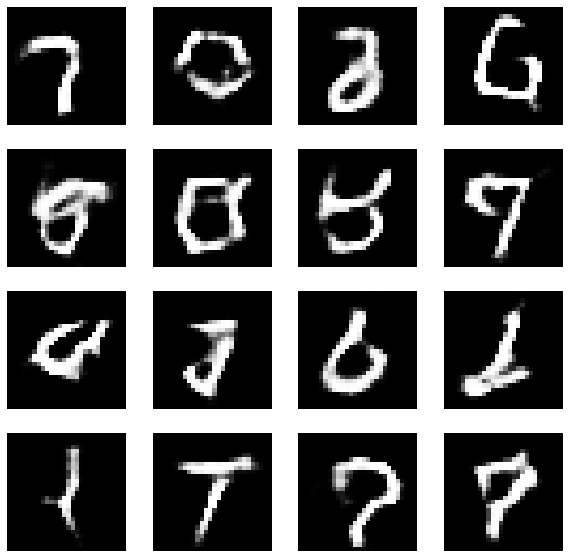

Epoch:  100


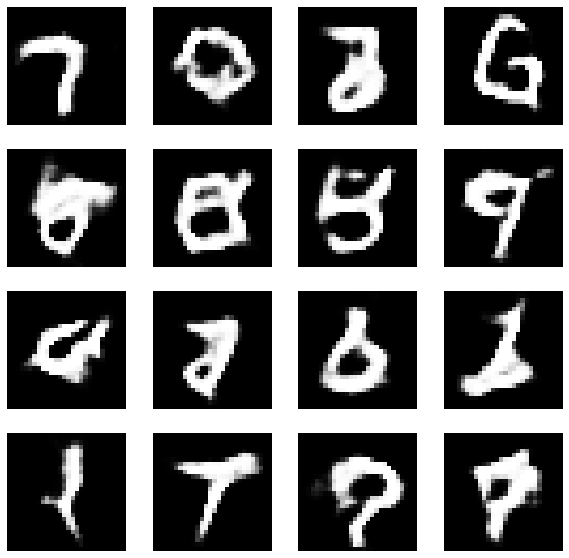

In [43]:
train(X_train, epochs, test_images)